In [ ]:
import pandas as pd
import gc
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle
from pandas.api.types import is_datetime64_any_dtype
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import calendar
from typing import List, Tuple, Dict, Optional
import xgboost as xgb
from tqdm import tqdm
from matplotlib import pyplot as plt
import zipfile
from scipy.stats.mstats import winsorize
import time


#de-allocate all dataframes
def free_up_all_gc_dataframes():
    print("scanning all df in gc...")

    all_df = get_all_dataframes()
    print(len(all_df), "number of df found")
    print("freeing up gc")
    for df in all_df:
        deallocate_dataframe(df)

    # Clear remaining references in globals
    for name in list(globals().keys()):
        if isinstance(globals()[name], pd.DataFrame):
            del globals()[name]

    gc.collect()  # Force garbage collection again
    print("gc cleanup completed")


#get all allocated dataframes
def get_all_dataframes():
    # Collect garbage to ensure up-to-date list of objects
    gc.collect()

    # List to hold references to DataFrame objects
    dataframes = []

    # Iterate over all objects tracked by the garbage collector
    for obj in gc.get_objects():
        # Check if the object is a DataFrame
        if isinstance(obj, pd.DataFrame):
            dataframes.append(obj)

    return dataframes


#use this to free up memory of unused df, use free_up_all_gc_dataframes() instead of calling this directly, as variable references
#needs to be cleared as well to free up memory allocation
def deallocate_dataframe(df):
    try:
        del df
        gc.collect()
        print("1 DataFrame memory deallocated successfully.")
    except Exception as e:
        print(f"An error occurred while deallocating memory: {e}")


#an enhance version of pd.read_csv with error handling and logging for large file reading
def read_csv_file(file_path):
    print(f"Loading {file_path}...", )
    try:
        df = pd.read_csv(file_path)
        print("CSV file read successfully.")
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: There was an error parsing the file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return None


#     Deallocates all DataFrame variables except those specified in the except_list.
def deallocate_dataframes_except(except_list):
    """
    Parameters:
    - except_list (list of str): Names of the DataFrames to keep.
    """
    # Collect garbage to ensure up-to-date list of objects
    gc.collect()

    # Collect garbage to ensure up-to-date list of objects
    gc.collect()

    # Get all global variables
    global_vars = globals()

    # Identify all DataFrame variables and delete if not in except_list
    for var_name in list(global_vars):  # Use list to copy keys to avoid dictionary size change during iteration
        var_value = global_vars[var_name]
        if isinstance(var_value, pd.DataFrame) and var_name not in except_list:
            del global_vars[var_name]  # Delete the variable
            print(f"Deleted DataFrame: {var_name}")

    gc.collect()  # Force garbage collection after deletion


def clean_initial_df(input_df: pd.DataFrame) -> pd.DataFrame:
    input_df['STATPERS'] = pd.to_datetime(input_df['STATPERS'])
    input_df['divyield'] = input_df['divyield'].str.replace('%', '').astype(float)
    if 'Unnamed: 0' in input_df.columns:
        input_df = input_df.drop(columns=['Unnamed: 0'])
    return input_df.fillna(0)


In [2]:
free_up_all_gc_dataframes()
cleaned_df = pd.read_csv('full_cleaned_data.csv')
cleaned_df['STATPERS'] = pd.to_datetime(cleaned_df['STATPERS'])

scanning all df in gc...
0 number of df found
freeing up gc
gc cleanup completed




/var/folders/_d/bmd_6z9569j64hgp6vdh94280000gn/T/ipykernel_85850/886127765.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_df = pd.read_csv('full_cleaned_data.csv')


# Define Parameters

In [ ]:
##########################################################
# Define Parameters #########
##########################################################

# Prediction period 
quarter = 1
year = 0

# windsorise Bound
bound = 0.05

# Rendom Forest Parameters
n_estimators = 500
max_depth = 10
min_samples_split = 5
model_name = "random_forest_model_winsorized"

### Make what quarter we are looking to estimate Dynamic 

In [4]:
def get_dynamic_columns(quarter, year):
    # Define the base columns that are always included
    base_cols = [
        'CAPEI', 'bm', 'evm', 'pe_exi', 'pe_inc',
        'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad',
        'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
        'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat',
        'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
        'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
        'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
        'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent',
        'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
        'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio',
        'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn',
        'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale',
        'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield'
    ]

    # Adjust columns based on the quarter
    if quarter in [1, 2, 3]:
        act_eps = f'ACT_{quarter}QTR_EPS'
        est_mean_eps = f'EST_{quarter}QTR_MEAN_EPS'
        # est_med_eps = f'EST_{quarter}QTR_MED_EPS'
    elif year in [1, 2]:
        act_eps = f'ACT_{year}YR_EPS'
        est_mean_eps = f'EST_{year}YR_MEAN_EPS'
        # est_med_eps = f'EST_{year}YR_MED_EPS'
    else:
        raise ValueError("Quarter must be 1, 2, 3 or Year must be 1 or 2")

    # Combine all columns
    dynamic_cols = [act_eps, est_mean_eps] + base_cols
    y_col = act_eps
    x_cols = [col for col in dynamic_cols if col not in y_col]

    return dynamic_cols, y_col, x_cols


dynamic_columns, y_column, x_columns = get_dynamic_columns(quarter, year)
# if 'EST_1QTR_MED_EPS' in x_columns:
#     x_columns.remove('EST_1QTR_MED_EPS')
# if 'EST_1QTR_MED_EPS' in dynamic_columns:
#     dynamic_columns.remove('EST_1QTR_MED_EPS')
print("Dynamic Columns:", dynamic_columns)
print("Y Columns:", y_column)
print("X Columns:", x_columns)
x_cols = x_columns
new_x_columns = [col for col in x_columns if col != 'EST_1QTR_MEAN_EPS']

Dynamic Columns: ['ACT_1QTR_EPS', 'EST_1QTR_MEAN_EPS', 'CAPEI', 'bm', 'evm', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield']
Y Columns: ACT_1QTR_EPS
X Columns: ['EST_1QTR_MEAN_EPS', 'CAPEI', 'bm', 'evm', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', '

### winsorizing all the values for the highest and lowest 1% to get rid of outliers and standardize all x variables

In [ ]:
def apply_winsorize(input_df: pd.DataFrame, upper_bound: float, lower_bound: float,
                    cols_to_apply: List[str]) -> pd.DataFrame:
    def winsorize_series(series, limits):
        return winsorize(series, limits=limits)

    # Apply winsorizing to all columns
    temp = input_df[cols_to_apply].apply(winsorize_series, limits=[upper_bound, lower_bound])
    input_df = input_df.assign(**temp.to_dict(orient='series'))
    return input_df

In [ ]:
# Dividend yield showing up as a string because of % sign
cleaned_df['divyield'] = cleaned_df['divyield'].str.replace('%', '', regex=False).astype(float) / 100.0

In [ ]:
cleaned_df = cleaned_df[cleaned_df['ACT_1QTR_EPS'].notna()]
winsorized_standardized_full_df = apply_winsorize(cleaned_df, bound, bound, dynamic_columns)

In [ ]:
winsorized_standardized_full_df['STATPERS'] = pd.to_datetime(winsorized_standardized_full_df['STATPERS'])
train_2013_df = winsorized_standardized_full_df[(winsorized_standardized_full_df['STATPERS'].dt.year == 2013)]

In [ ]:
### Need to think more about the testing component
test_2014_01_df = winsorized_standardized_full_df[
    (winsorized_standardized_full_df['STATPERS'].dt.year == 2014) & (winsorized_standardized_full_df['STATPERS'].dt.month == 1)]

#print(train_2013_df, test_2014_01_df)

In [ ]:
#take actual data as y value and estimate data with WRDS as x values
y_train = train_2013_df[y_column]
y_test = test_2014_01_df[y_column]


## X with analyst estimate
x_cols = x_columns

x_train = train_2013_df[x_cols]
x_test = test_2014_01_df[x_cols]

## X without analyst estimates
new_x_train = train_2013_df[new_x_columns]
new_x_test = test_2014_01_df[new_x_columns]

## 1- Training using XGBoost

### 1-a. Including Analyst estimates

In [ ]:
xgb_xgb = xgb.XGBRegressor(n_estimators=n_estimators,
                           max_depth=max_depth,
                           random_state=0)

In [12]:
xgb_xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
 colsample_bylevel=None, colsample_bynode=None,
 colsample_bytree=None, early_stopping_rounds=None,
 enable_categorical=False, eval_metric=None, feature_types=None,
 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
 interaction_constraints=None, learning_rate=None, max_bin=None,
 max_cat_threshold=None, max_cat_to_onehot=None,
 max_delta_step=None, max_depth=10, max_leaves=None,
 min_child_weight=None, missing=nan, monotone_constraints=None,
 n_estimators=500, n_jobs=None, num_parallel_tree=None,
 predictor=None, random_state=0, ...) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. XGBRegressor XGBRegressor(base_score=None, booster=None, callbacks=None,
 colsample_bylevel=None, colsample_bynode=None,
 colsample_bytree=None, early_stopping_rounds=None,
 enable_categorical=False, eval_metric=None, feature_types=None,
 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
 interaction_constraints=None, learning_rate=None, max_bin=None,
 max_cat_threshold=None, max_cat_to_onehot=None,
 max_delta_step=None, max_depth=10, max_leaves=None,
 min_child_weight=None, missing=nan, monotone_constraints=None,
 n_estimators=500, n_jobs=None, num_parallel_tree=None,
 predictor=None, random_state=0, ...)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

### 1-b. Excluding Analyst estimates

In [ ]:
xgb_xgb_ex_analyst = xgb.XGBRegressor(n_estimators=n_estimators,
                           max_depth=max_depth,
                           random_state=0)

In [14]:
xgb_xgb_ex_analyst.fit(new_x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
 colsample_bylevel=None, colsample_bynode=None,
 colsample_bytree=None, early_stopping_rounds=None,
 enable_categorical=False, eval_metric=None, feature_types=None,
 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
 interaction_constraints=None, learning_rate=None, max_bin=None,
 max_cat_threshold=None, max_cat_to_onehot=None,
 max_delta_step=None, max_depth=10, max_leaves=None,
 min_child_weight=None, missing=nan, monotone_constraints=None,
 n_estimators=500, n_jobs=None, num_parallel_tree=None,
 predictor=None, random_state=0, ...) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. XGBRegressor XGBRegressor(base_score=None, booster=None, callbacks=None,
 colsample_bylevel=None, colsample_bynode=None,
 colsample_bytree=None, early_stopping_rounds=None,
 enable_categorical=False, eval_metric=None, feature_types=None,
 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
 interaction_constraints=None, learning_rate=None, max_bin=None,
 max_cat_threshold=None, max_cat_to_onehot=None,
 max_delta_step=None, max_depth=10, max_leaves=None,
 min_child_weight=None, missing=nan, monotone_constraints=None,
 n_estimators=500, n_jobs=None, num_parallel_tree=None,
 predictor=None, random_state=0, ...)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

## 2- Training using RandomForest

### 2-a. Including Analyst estimates

In [ ]:
xgb_rf_model = xgb.XGBRFRegressor(n_estimators=n_estimators,
                               max_depth=max_depth,
                               random_state=0)

In [16]:
xgb_rf_model.fit(x_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
 colsample_bylevel=None, colsample_bytree=None,
 early_stopping_rounds=None, enable_categorical=False,
 eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
 grow_policy=None, importance_type=None,
 interaction_constraints=None, max_bin=None,
 max_cat_threshold=None, max_cat_to_onehot=None,
 max_delta_step=None, max_depth=10, max_leaves=None,
 min_child_weight=None, missing=nan, monotone_constraints=None,
 n_estimators=500, n_jobs=None, num_parallel_tree=None,
 objective='reg:squarederror', predictor=None, random_state=0,
 reg_alpha=None, ...) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. XGBRFRegressor XGBRFRegressor(base_score=None, booster=None, callbacks=None,
 colsample_bylevel=None, colsample_bytree=None,
 early_stopping_rounds=None, enable_categorical=False,
 eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
 grow_policy=None, importance_type=None,
 interaction_constraints=None, max_bin=None,
 max_cat_threshold=None, max_cat_to_onehot=None,
 max_delta_step=None, max_depth=10, max_leaves=None,
 min_child_weight=None, missing=nan, monotone_constraints=None,
 n_estimators=500, n_jobs=None, num_parallel_tree=None,
 objective='reg:squarederror', predictor=None, random_state=0,
 reg_alpha=None, ...)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=10, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=500, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=0,
               reg_alpha=None, ...)

### 2-b. Excluding Analyst estimates

In [ ]:
xgb_rf_model_ex_analyst = xgb.XGBRFRegressor(n_estimators=n_estimators,
                               max_depth=max_depth,
                               random_state=0)

In [18]:
xgb_rf_model_ex_analyst.fit(new_x_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
 colsample_bylevel=None, colsample_bytree=None,
 early_stopping_rounds=None, enable_categorical=False,
 eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
 grow_policy=None, importance_type=None,
 interaction_constraints=None, max_bin=None,
 max_cat_threshold=None, max_cat_to_onehot=None,
 max_delta_step=None, max_depth=10, max_leaves=None,
 min_child_weight=None, missing=nan, monotone_constraints=None,
 n_estimators=500, n_jobs=None, num_parallel_tree=None,
 objective='reg:squarederror', predictor=None, random_state=0,
 reg_alpha=None, ...) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. XGBRFRegressor XGBRFRegressor(base_score=None, booster=None, callbacks=None,
 colsample_bylevel=None, colsample_bytree=None,
 early_stopping_rounds=None, enable_categorical=False,
 eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
 grow_policy=None, importance_type=None,
 interaction_constraints=None, max_bin=None,
 max_cat_threshold=None, max_cat_to_onehot=None,
 max_delta_step=None, max_depth=10, max_leaves=None,
 min_child_weight=None, missing=nan, monotone_constraints=None,
 n_estimators=500, n_jobs=None, num_parallel_tree=None,
 objective='reg:squarederror', predictor=None, random_state=0,
 reg_alpha=None, ...)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=10, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=500, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=0,
               reg_alpha=None, ...)

# Summary of Prediction Results

In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# Predictions with models using the analyst estimates
y_train_pred_xgb = xgb_xgb.predict(x_train)
y_test_pred_xgb = xgb_xgb.predict(x_test)

# Predictions with models excluding the analyst estimates
y_train_pred_xgb_ex_analyst = xgb_xgb_ex_analyst.predict(new_x_train)
y_test_pred_xgb_ex_analyst = xgb_xgb_ex_analyst.predict(new_x_test)

# Predictions with random forest models using the analyst estimates
y_train_pred_rf = xgb_rf_model.predict(x_train)
y_test_pred_rf = xgb_rf_model.predict(x_test)

# Predictions with random forest models excluding the analyst estimates
y_train_pred_rf_ex_analyst = xgb_rf_model_ex_analyst.predict(new_x_train)
y_test_pred_rf_ex_analyst = xgb_rf_model_ex_analyst.predict(new_x_test)

In [21]:
# Define a function to compute metrics
def compute_metrics(y_true_train, y_pred_train, y_true_test, y_pred_test):
    in_sample_r2 = r2_score(y_true_train, y_pred_train)
    out_of_sample_r2 = r2_score(y_true_test, y_pred_test)
    in_sample_mse = mean_squared_error(y_true_train, y_pred_train)
    out_of_sample_mse = mean_squared_error(y_true_test, y_pred_test)
    
    return {
        "In-sample R²": in_sample_r2,
        "Out-of-sample R²": out_of_sample_r2,
        "In-sample MSE": in_sample_mse,
        "Out-of-sample MSE": out_of_sample_mse
    }

# Compute and display metrics for each model
metrics_xgb = compute_metrics(y_train, y_train_pred_xgb, y_test, y_test_pred_xgb)
metrics_xgb_ex_analyst = compute_metrics(y_train, y_train_pred_xgb_ex_analyst, y_test, y_test_pred_xgb_ex_analyst)
metrics_rf = compute_metrics(y_train, y_train_pred_rf, y_test, y_test_pred_rf)
metrics_rf_ex_analyst = compute_metrics(y_train, y_train_pred_rf_ex_analyst, y_test, y_test_pred_rf_ex_analyst)

# Assuming the compute_metrics function and the prediction variables are defined

# Creating a dictionary for DataFrame
data = {
    'Model': [
        'XGB with Analyst Estimates', 
        'XGB without Analyst Estimates', 
        'RF with Analyst Estimates', 
        'RF without Analyst Estimates'
    ],
    'In-sample R²': [
        metrics_xgb['In-sample R²'], 
        metrics_xgb_ex_analyst['In-sample R²'], 
        metrics_rf['In-sample R²'], 
        metrics_rf_ex_analyst['In-sample R²']
    ],
    'Out-of-sample R²': [
        metrics_xgb['Out-of-sample R²'], 
        metrics_xgb_ex_analyst['Out-of-sample R²'], 
        metrics_rf['Out-of-sample R²'], 
        metrics_rf_ex_analyst['Out-of-sample R²']
    ],
    'In-sample MSE': [
        metrics_xgb['In-sample MSE'], 
        metrics_xgb_ex_analyst['In-sample MSE'], 
        metrics_rf['In-sample MSE'], 
        metrics_rf_ex_analyst['In-sample MSE']
    ],
    'Out-of-sample MSE': [
        metrics_xgb['Out-of-sample MSE'], 
        metrics_xgb_ex_analyst['Out-of-sample MSE'], 
        metrics_rf['Out-of-sample MSE'], 
        metrics_rf_ex_analyst['Out-of-sample MSE']
    ]
}

# Creating the DataFrame
results_df = pd.DataFrame(data)

# Display the DataFrame
display(results_df)

Model 
 In-sample R² 
 Out-of-sample R² 
 In-sample MSE 
 Out-of-sample MSE 
 
 
 
 
 0 
 XGB with Analyst Estimates 
 0.998140 
 0.966823 
 0.000610 
 0.011582 
 
 
 1 
 XGB without Analyst Estimates 
 0.987081 
 0.924321 
 0.004237 
 0.026420 
 
 
 2 
 RF with Analyst Estimates 
 0.948510 
 0.909934 
 0.016890 
 0.031442 
 
 
 3 
 RF without Analyst Estimates 
 0.731674 
 0.693130 
 0.088015 
 0.107129

                           Model  In-sample R²  Out-of-sample R²  \
0     XGB with Analyst Estimates      0.998140          0.966823   
1  XGB without Analyst Estimates      0.987081          0.924321   
2      RF with Analyst Estimates      0.948510          0.909934   
3   RF without Analyst Estimates      0.731674          0.693130   

   In-sample MSE  Out-of-sample MSE  
0       0.000610           0.011582  
1       0.004237           0.026420  
2       0.016890           0.031442  
3       0.088015           0.107129  

## Feature importance using built in function

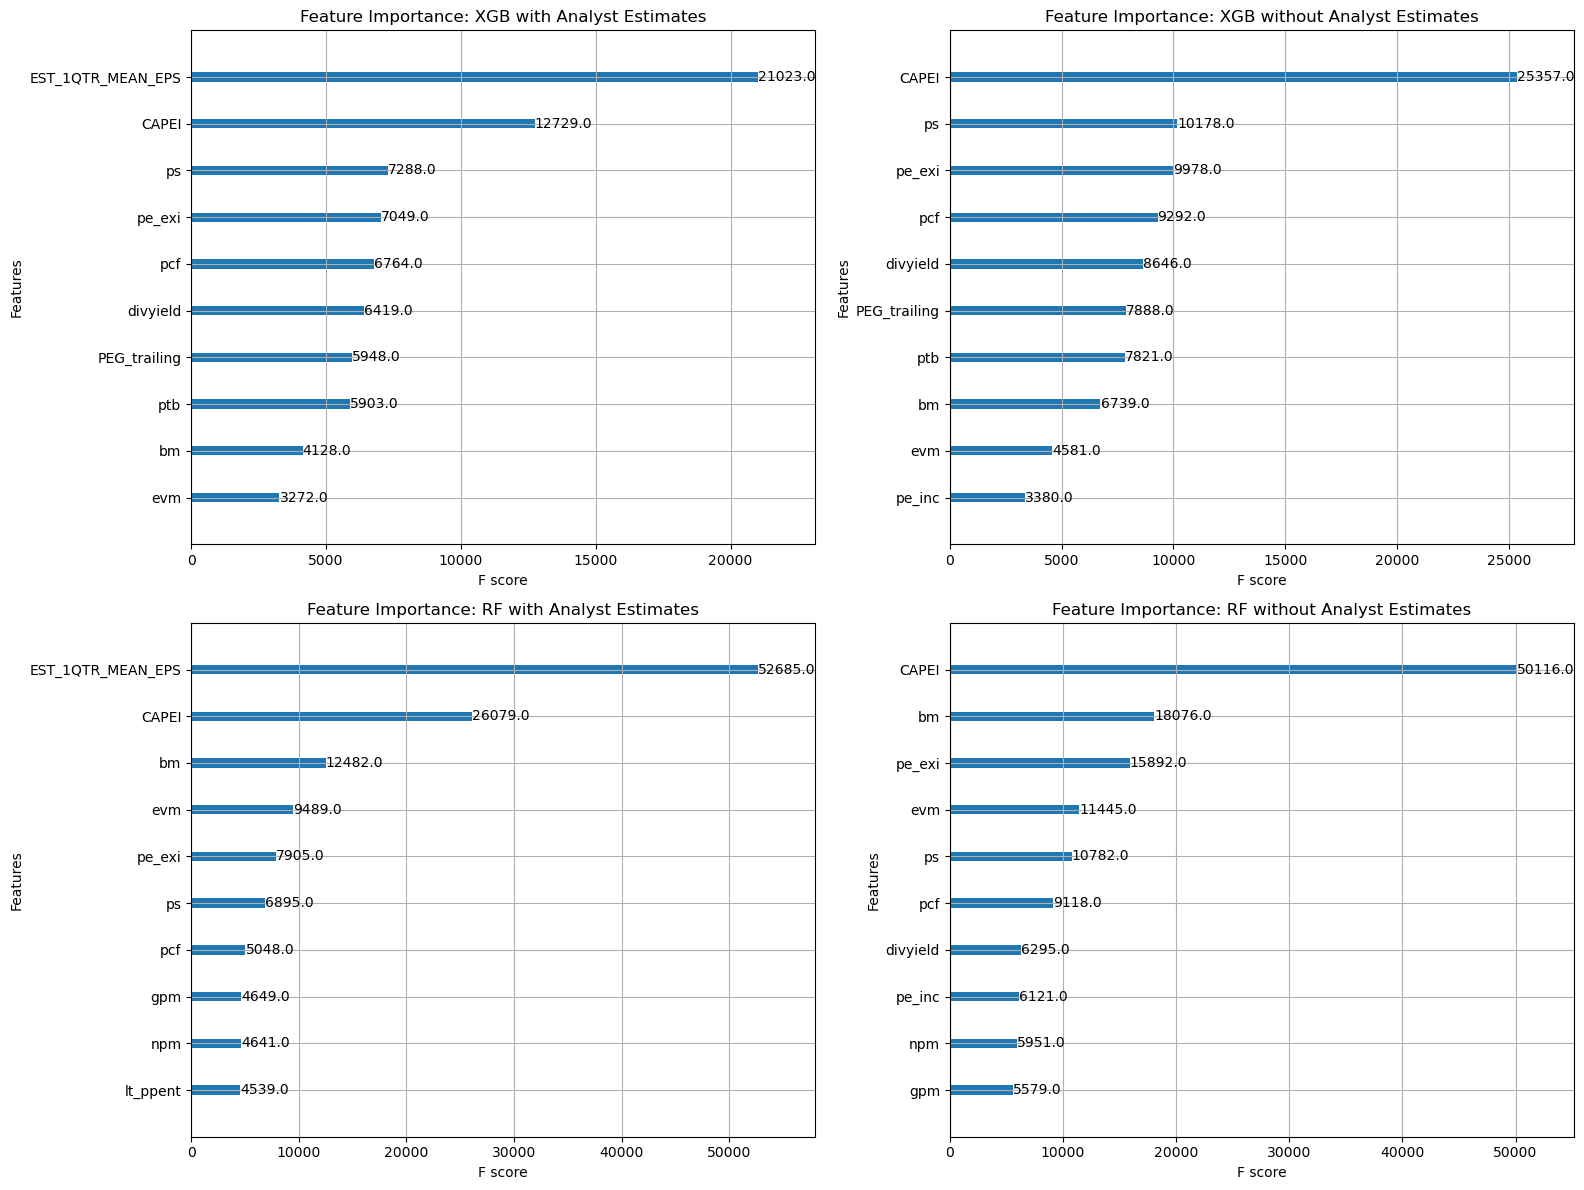

<Figure size 1600x1200 with 4 Axes>

In [22]:
# Assuming your XGBoost models are named as mentioned and are trained
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# XGB with Analyst Estimates
xgb.plot_importance(xgb_xgb, ax=ax[0, 0], title='Feature Importance: XGB with Analyst Estimates', max_num_features=10)

# XGB without Analyst Estimates
xgb.plot_importance(xgb_xgb_ex_analyst, ax=ax[0, 1], title='Feature Importance: XGB without Analyst Estimates', max_num_features=10)

# Assuming xgb_rf_model and xgb_rf_model_ex_analyst are also XGBoost-based models
xgb.plot_importance(xgb_rf_model, ax=ax[1, 0], title='Feature Importance: RF with Analyst Estimates', max_num_features=10)
xgb.plot_importance(xgb_rf_model_ex_analyst, ax=ax[1, 1], title='Feature Importance: RF without Analyst Estimates', max_num_features=10)

plt.tight_layout()
plt.show()

fig.savefig('feature_importance_2013_weight.png')

### Get Top 5 Important Features for a Given Trained Model

In [ ]:
def get_top_important_features(topn: Optional[int],
                               model_trained: xgb.XGBRFRegressor,
                               original_test_x: pd.DataFrame,
                               original_test_y: pd.DataFrame) -> List[Tuple[str, float]]:
    original_test_x_copy = original_test_x.copy(deep=True)
    y_pred_no_dropped_features = model_trained.predict(original_test_x_copy)
    r2_no_dropped_features = r2_score(original_test_y, y_pred_no_dropped_features)
    feature_names = original_test_x_copy.columns
    res = []
    for idx, feature_name in tqdm(enumerate(feature_names), total=len(feature_names)):
        temp = original_test_x_copy[feature_name].copy()
        original_test_x_copy[feature_name] = original_test_x_copy[feature_name].apply(lambda i: np.nan)
        # print(f"{feature_name=}, {original_test_x_copy.iloc[0, idx]=}")
        predictions_cur = model_trained.predict(original_test_x_copy)
        new_r2 = r2_score(original_test_y.values.ravel(), predictions_cur)
        delta_r2 = abs(r2_no_dropped_features - new_r2)
        res.append((feature_name, delta_r2))
        original_test_x_copy.loc[:, feature_name] = temp
        # print(f"{feature_name=}, {original_test_x_copy.iloc[0, idx]=}")
    res = sorted(res, key=lambda tup: tup[1], reverse=True)
    if topn is None:
        return res
    else:
        return res[:topn]

In [ ]:
from sklearn.inspection import permutation_importance
from typing import List, Tuple


def get_top_important_features_permutation(topn: int,
                                           model_trained,
                                           original_test_x,
                                           original_test_y) -> List[Tuple[str, float]]:
    # Calculate permutation importance
    result = permutation_importance(model_trained, original_test_x, original_test_y, n_repeats=10, random_state=42,
                                    scoring='r2')

    # Extract feature importances
    importances = result.importances_mean

    # Get feature names
    feature_names = original_test_x.columns

    # Combine feature names with their importance scores
    feature_importance_pairs = [(feature, importance) for feature, importance in zip(feature_names, importances)]

    # Sort features by importance
    feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)

    # Return the top 'n' features
    return feature_importance_pairs[:topn]

In [69]:
tt1 = get_top_important_features(None, xgb_xgb, x_test, y_test)

100%|██████████| 68/68 [00:00<00:00, 95.58it/s]


In [34]:
#tt1

[('EST_1QTR_MEAN_EPS', 4.053762811912003),
 ('pretret_earnat', 0.4006809496783752),
 ('evm', 0.19454419305486326),
 ('rect_turn', 0.17835422783001942),
 ('opmad', 0.17666667131652347),
 ('roce', 0.13798750961464779),
 ('sale_nwc', 0.09736493550172542),
 ('npm', 0.05499252133898369),
 ('debt_ebitda', 0.05110449790033589),
 ('lt_ppent', 0.05090772433596502),
 ('ptb', 0.04165051668949704),
 ('ps', 0.03315555597180975),
 ('ptpm', 0.03169771229273499),
 ('GProf', 0.02550322168329522),
 ('ocf_lct', 0.02292972437753904),
 ('CAPEI', 0.022234586518267263),
 ('roe', 0.021792099583484048),
 ('curr_debt', 0.017782299153573655),
 ('gpm', 0.017603298691227787),
 ('accrual', 0.01641662957671075),
 ('pcf', 0.01578618523591635),
 ('PEG_trailing', 0.01385256350087305),
 ('pe_exi', 0.013711962862745786),
 ('opmbd', 0.013305727547241353),
 ('debt_capital', 0.013252954273897721),
 ('aftret_invcapx', 0.011565202291334176),
 ('intcov_ratio', 0.010907004422935684),
 ('cash_ratio', 0.010308823140884882),
 ('pr

In [ ]:
ttP1 = get_top_important_features_permutation(20, xgb_xgb, x_test, y_test)

In [67]:
ttP1

[('EST_1QTR_MEAN_EPS', 1.2392853306279086),
 ('pretret_earnat', 0.09192977751112187),
 ('opmad', 0.05522394017727143),
 ('evm', 0.03156105869880049),
 ('profit_lct', 0.025472602673006474),
 ('rect_turn', 0.02292728091133108),
 ('npm', 0.017351663363555026),
 ('roce', 0.016054194264475907),
 ('CAPEI', 0.01461770369234774),
 ('cash_lt', 0.013697848657452938),
 ('lt_ppent', 0.01290859034101215),
 ('ps', 0.01244860786069305),
 ('roa', 0.010604194069588579),
 ('debt_ebitda', 0.009239707025865563),
 ('PEG_trailing', 0.008979017574114512),
 ('sale_nwc', 0.007860692666665758),
 ('pcf', 0.007301698454965944),
 ('ptpm', 0.0067608791326509874),
 ('curr_ratio', 0.006483910147993088),
 ('bm', 0.006433261464364371)]

### Rolling window
Train using the first 12 month, and test it using the month immediately after. Then roll the window to next month. For each train/test pair, note down the top 5 most important features

In [ ]:
def save_to_pickle(pickle_root_dir: str, 
                   rolling_res, 
                   rolling_r_2_insample, 
                   rolling_r_2_outsample)->None:
    with open(os.path.join(pickle_root_dir, 'rolling_res_dropfeautre.pickle'), 'wb') as handle1:
        pickle.dump(rolling_res, handle1)

    with open(os.path.join(pickle_root_dir, 'rolling_r_2_insample_dropfeautre.pickle'), 'wb') as handle2:
        pickle.dump(rolling_r_2_insample, handle2)

    with open(os.path.join(pickle_root_dir, 'rolling_r_2_outsample_dropfeautre.pickle'), 'wb') as handle3:
        pickle.dump(rolling_r_2_outsample, handle3)

In [91]:
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error


import pandas as pd

# Function to get the unique starting and ending month and year
def get_start_end_dates(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column])
    start_date = df[date_column].min()
    end_date = df[date_column].max()
    start_year = start_date.year
    start_month = start_date.month
    end_year = end_date.year
    end_month = end_date.month
    return (start_year, start_month), (end_year, end_month)


def rolling(input_df: pd.DataFrame, 
            model_constructor_xgb, model_constructor_rf,
            pickle_root_dir: str,
            x_columns: list, new_x_columns: list,
            y_column: str,
            first_date: Optional[datetime] = None,
            last_date: Optional[datetime] = None) -> pd.DataFrame:

    if first_date is None:
        first_date = input_df.iloc[0]['STATPERS']
    if last_date is None:
        last_date = input_df.iloc[-1]['STATPERS']
        
    months_apart = (last_date.year - first_date.year) * 12 + last_date.month - first_date.month
    assert months_apart >= 12

    start_date = datetime(year=first_date.year, month=first_date.month, day=1)
    end_date = datetime(year=last_date.year, month=last_date.month, day=1)

    results = []

    while (start_date + relativedelta(years=1)) < end_date:
        train_start_date = start_date
        train_end_date = start_date + relativedelta(years=1) - timedelta(days=1)
        test_start_date = train_end_date + timedelta(days=1)
        test_end_date = test_start_date + relativedelta(months=1) - timedelta(days=1)
        

        train_df = input_df[(input_df['STATPERS'] >= train_start_date) & (input_df['STATPERS'] <= train_end_date)]
        test_df = input_df[(input_df['STATPERS'] >= test_start_date) & (input_df['STATPERS'] <= test_end_date)]
        
        
        #print('train date range: ',get_start_end_dates(train_df, 'STATPERS'))
        #print('test date range: ',get_start_end_dates(test_df, 'STATPERS'))
        
        
        # Train and Test DataFrames for both feature sets
        data_sets = {
            'with_analyst': (train_df[x_columns], test_df[x_columns], x_columns),
            'without_analyst': (train_df[new_x_columns], test_df[new_x_columns], new_x_columns)
        }
        
        # Models to train
        models = {
            'xgb': model_constructor_xgb,
            'rf': model_constructor_rf
        }
        
        for model_key, model_constructor in models.items():
            for data_key, (x_train_cur_df, x_test_cur_df, feature_names) in data_sets.items():
                
                y_train_cur_df = train_df[y_column]
                
                y_test_cur_df = test_df[y_column]
                
                # Initialize and train model
                model_cur = model_constructor()
                model_cur.fit(x_train_cur_df, y_train_cur_df)
                
                # Compute predictions and metrics
                y_train_pred = model_cur.predict(x_train_cur_df)
                y_test_pred = model_cur.predict(x_test_cur_df)
                
                feature_dict = {}
                feature_importance = model_cur.feature_importances_
                
                #feature_importance 
                sorted_idx = feature_importance.argsort()
                feature_dict = {feature_names[i]: feature_importance[i] for i in sorted_idx}
                
                #feature_importance_RSquared
                feature_dict_RSquared = get_top_important_features(None, model_cur, x_test_cur_df, y_test_cur_df)
                
                
                ### Something seem to be off
                # Calculate earning surprise out of sample model
                earning_surprise_model = np.mean((y_test_pred - y_test_cur_df) / y_test_cur_df)
                
                # Calculate earning surprise by analyst estimate
                earning_surprise_analyst = np.mean((test_df['EST_1QTR_MEAN_EPS'] - y_test_cur_df) / y_test_cur_df)
                
                # Model Estimate earning vs Analyst
                earning_modelVSanalyst = np.mean((y_test_pred - test_df['EST_1QTR_MEAN_EPS']) / test_df['EST_1QTR_MEAN_EPS'])
                
                

                # Append results
                with_analyst = 'no' if 'EST_1QTR_MEAN_EPS' not in feature_names else 'yes'
                results.append({
                    'date': test_start_date,
                    'model_type': model_key,
                    'with_analyst': with_analyst,
                    'train_r2': r2_score(y_train_cur_df, y_train_pred),
                    'test_r2': r2_score(y_test_cur_df, y_test_pred),
                    'train_mse': mean_squared_error(y_train_cur_df, y_train_pred),
                    'test_mse': mean_squared_error(y_test_cur_df, y_test_pred),
                    'feature_importances': feature_dict,
                    'feature_dict_RSquared': feature_dict_RSquared,
                    'Earning_Surprise_Model':earning_surprise_model,
                    'Earning_Surprise_Analyst':earning_surprise_analyst,     
                    'Earning_Model_VS_Analyst':earning_modelVSanalyst
                })

        # Increment start date by one month for the next iteration
        start_date = start_date + relativedelta(months=1)

    # Convert results to DataFrame
    return pd.DataFrame(results)

# Example model constructors/ need to make it dynamic
def xgb_model_constructor():
    return xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=0)

def rf_model_constructor():
    return xgb.XGBRFRegressor(n_estimators=100, max_depth=3, random_state=0)


cutoff_date = pd.Timestamp('1990-07-01')

# Filter the DataFrame to include only entries before 2016
filtered_df = winsorized_standardized_full_df[winsorized_standardized_full_df['STATPERS'] < cutoff_date]

cutoff_date = pd.Timestamp('1985-01-01')
filtered_df = filtered_df[filtered_df['STATPERS'] > cutoff_date]

# Call the function
metrics = rolling(filtered_df, xgb_model_constructor, rf_model_constructor, '/data/xgb_rf_pickled_res', x_columns, new_x_columns, y_column)

100%|██████████| 67/67 [00:00<00:00, 374.83it/s]


In [ ]:
metrics.to_csv('metrics_5%_full.csv')


Plot saved as: performance_metrics_over_time.png


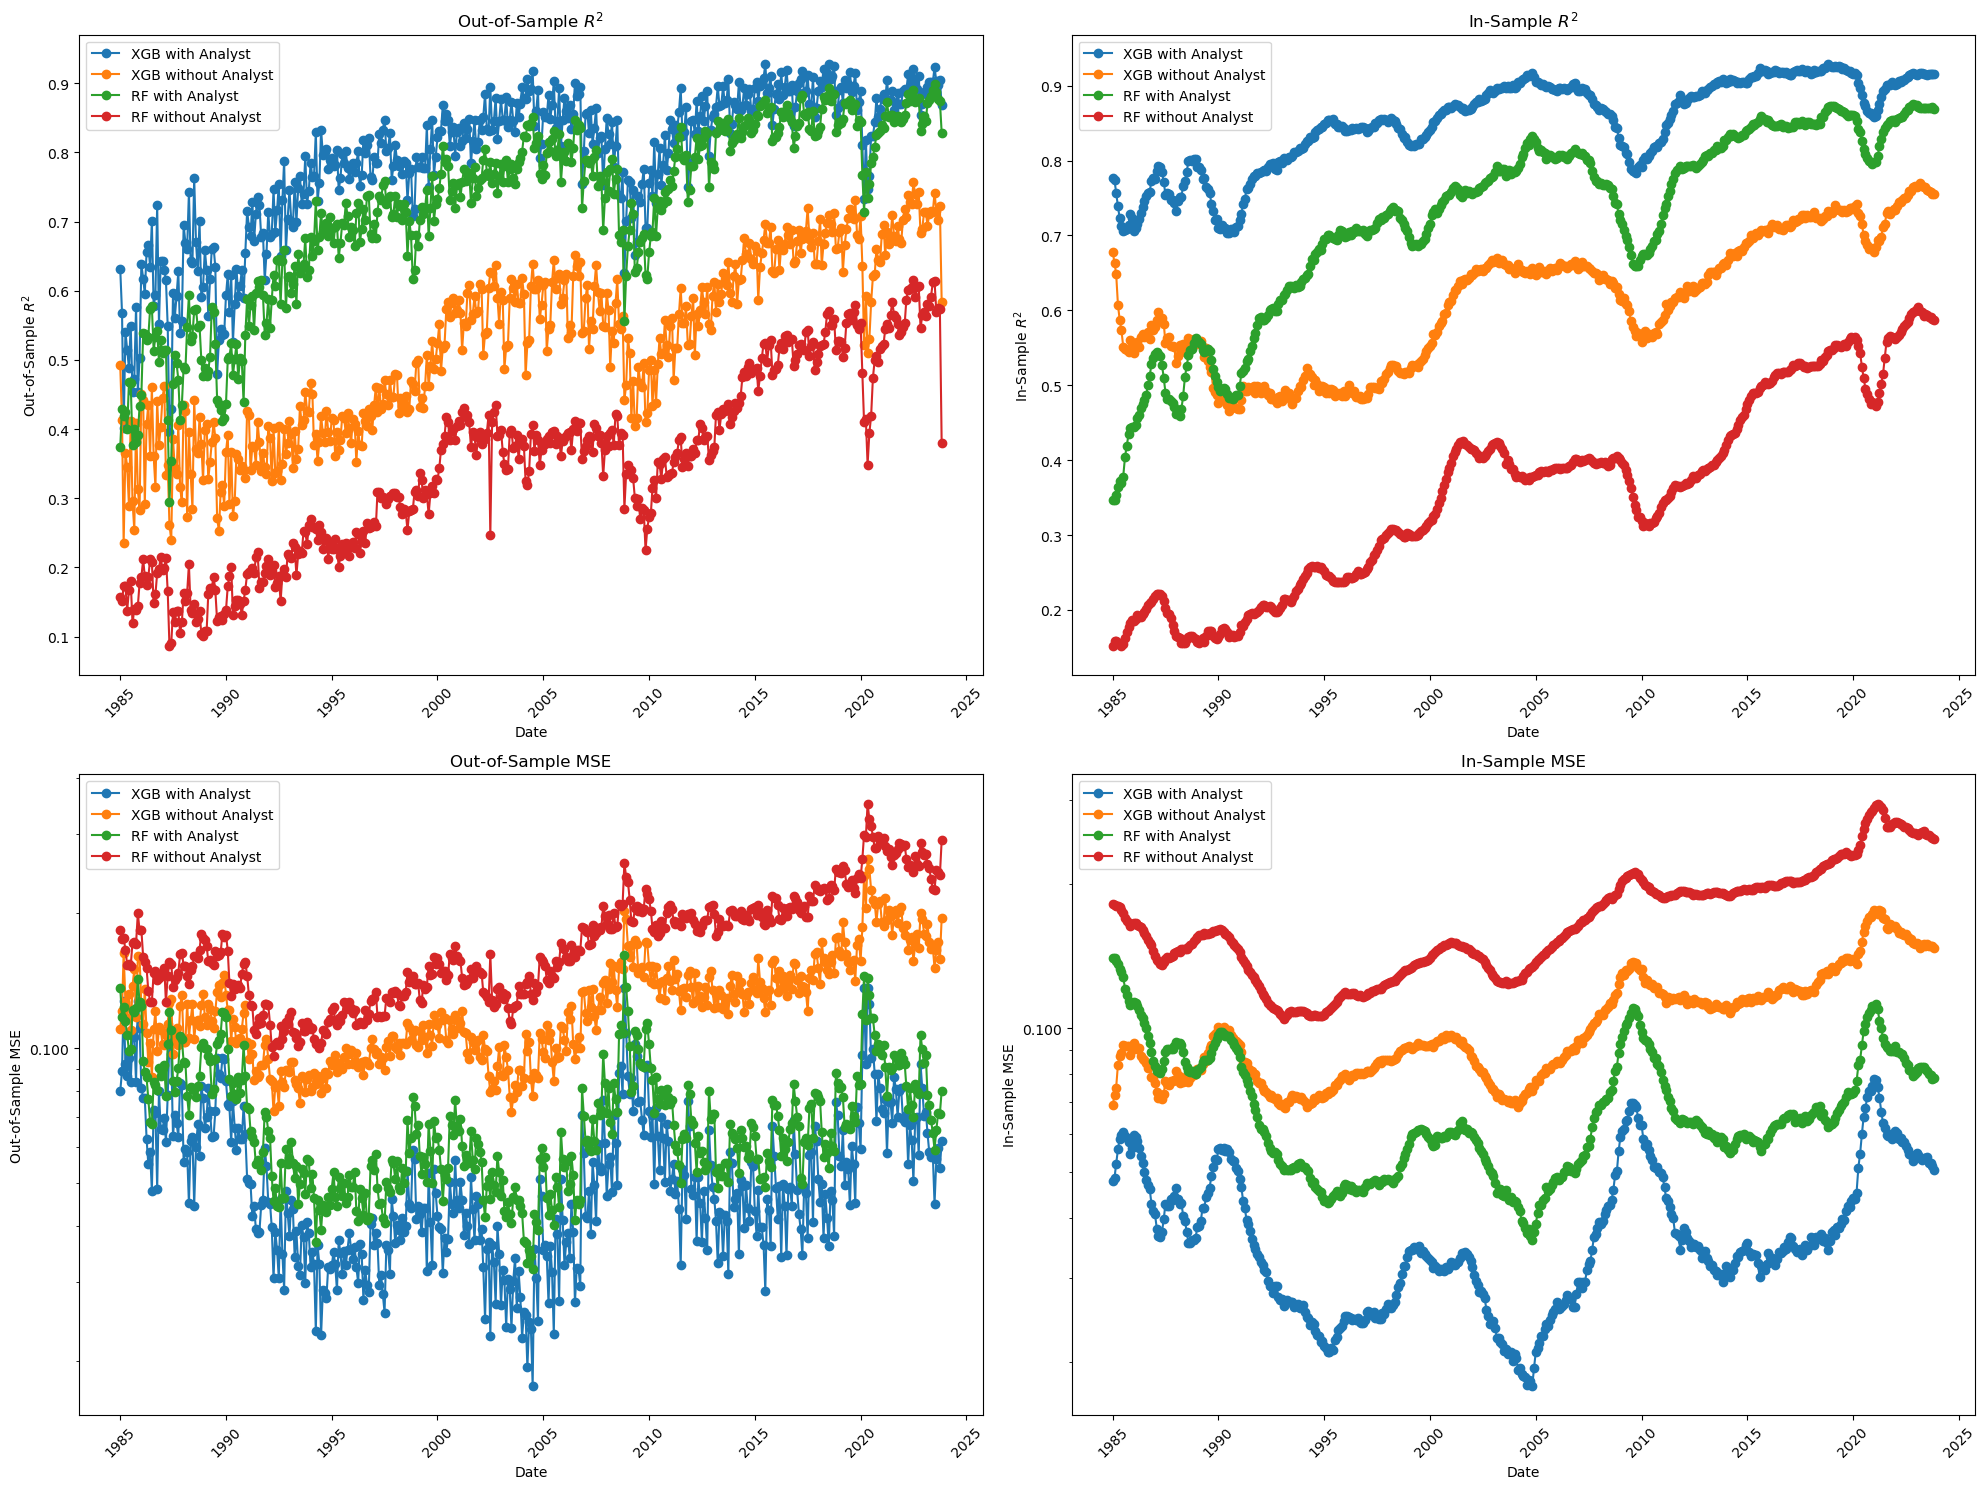

<Figure size 2000x1500 with 4 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

def plot_performance_metrics(df, output_filename="performance_metrics.png"):
    # Prepare the DataFrame by ensuring 'date' is a datetime type
    df['date'] = pd.to_datetime(df['date'])

    # Set up the plotting area
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))  # Increased size for clarity
    axes = axes.flatten()

    # Titles and metrics to plot
    titles = ['Out-of-Sample $R^2$', 'In-Sample $R^2$', 'Out-of-Sample MSE', 'In-Sample MSE']
    metrics = ['test_r2', 'train_r2', 'test_mse', 'train_mse']

    # Loop through each metric to create a subplot
    for i, metric in enumerate(metrics):
        # Filter data for each combination and plot
        for model_type in ['xgb', 'rf']:
            for with_analyst in ['yes', 'no']:
                label = f"{model_type.upper()} {'with' if with_analyst == 'yes' else 'without'} Analyst"
                subset = df[(df['model_type'] == model_type) & (df['with_analyst'] == with_analyst)]
                subset = subset.sort_values('date')
                axes[i].plot(subset['date'], subset[metric], label=label, marker='o', linestyle='-')

        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(titles[i])

        # Enhance y-axis label readability
        axes[i].yaxis.set_major_locator(ticker.MaxNLocator(10))  # Dynamically set the number of ticks
        if 'mse' in metric:
            axes[i].set_yscale('log')  # Use logarithmic scale for MSE to handle wide ranges
            axes[i].yaxis.set_major_formatter(ticker.ScalarFormatter())  # Use scalar formatter for log scale

        # Rotate labels if needed
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(45)

        axes[i].legend()

    plt.tight_layout()
    plt.savefig(output_filename)  # Save the figure to a file
    plt.show()
    print(f"Plot saved as: {output_filename}")

# Example usage
plot_performance_metrics(metrics, "performance_metrics_over_time.png")

In [ ]:

from collections import defaultdict

def get_feature_importances_by_configuration(df):
    # Initialize a dictionary to store DataFrames for each configuration
    configurations = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

    # Process each row in the DataFrame
    for _, row in df.iterrows():
        date = row['date']
        model_type = row['model_type']
        with_analyst = row['with_analyst']
        total_importance = sum(row['feature_importances'].values())

        for feature, importance in row['feature_importances'].items():
            if total_importance > 0:  # Avoid division by zero
                configurations[(model_type, with_analyst)][date][feature] += importance

    # Normalize the importances and convert to DataFrame
    result_dfs = {}
    for config, data in configurations.items():
        # Create DataFrame from the nested dictionary
        temp_df = pd.DataFrame.from_dict(data, orient='index').fillna(0)
        # Normalize the importances to sum to 100% per row
        temp_df = temp_df.div(temp_df.sum(axis=1), axis=0) * 100
        result_dfs[config] = temp_df

    return result_dfs

# Example usage, assuming `metrics_df` is your DataFrame
config_dfs = get_feature_importances_by_configuration(metrics)



Plot saved as Feature_Importances_perc_(F_Measure)_for_XGB_Model_with_Analyst.png



Plot saved as Feature_Importances_perc_(F_Measure)_for_XGB_Model_without_Analyst.png



Plot saved as Feature_Importances_perc_(F_Measure)_for_RF_Model_with_Analyst.png



Plot saved as Feature_Importances_perc_(F_Measure)_for_RF_Model_without_Analyst.png


/var/folders/_d/bmd_6z9569j64hgp6vdh94280000gn/T/ipykernel_85850/4075167655.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()



/var/folders/_d/bmd_6z9569j64hgp6vdh94280000gn/T/ipykernel_85850/4075167655.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()



/var/folders/_d/bmd_6z9569j64hgp6vdh94280000gn/T/ipykernel_85850/4075167655.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()



/var/folders/_d/bmd_6z9569j64hgp6vdh94280000gn/T/ipykernel_85850/4075167655.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()




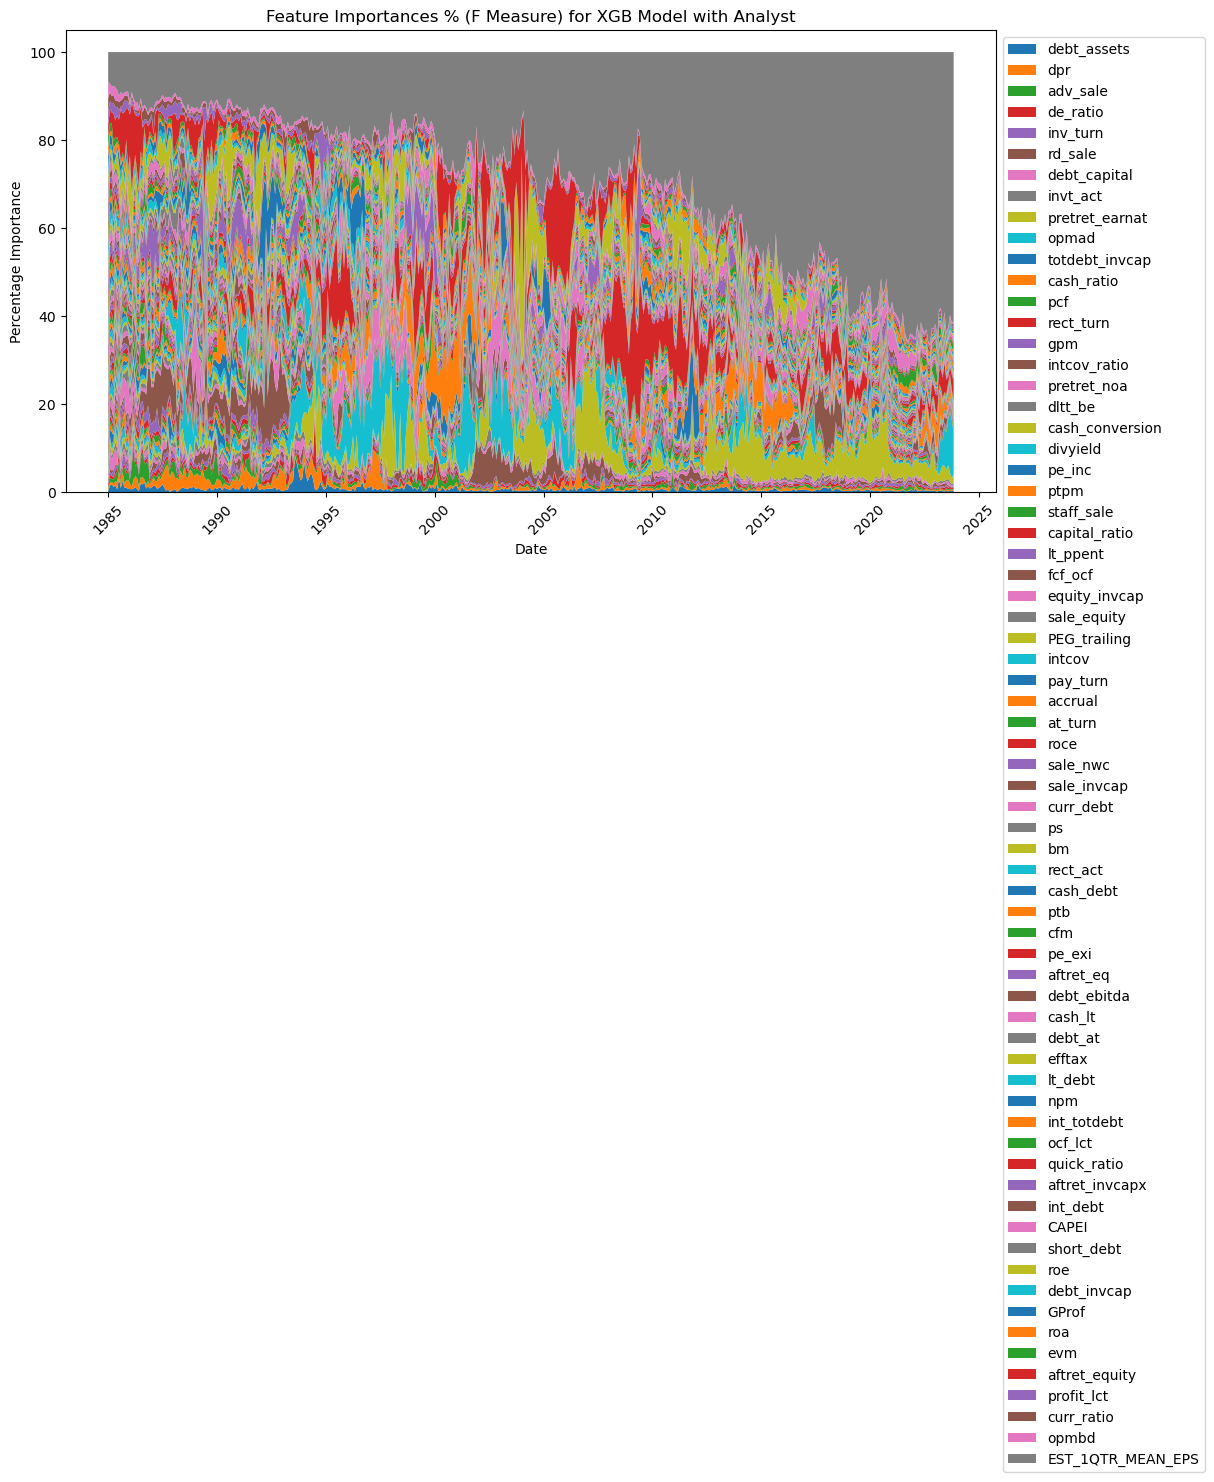

<Figure size 1200x600 with 1 Axes>

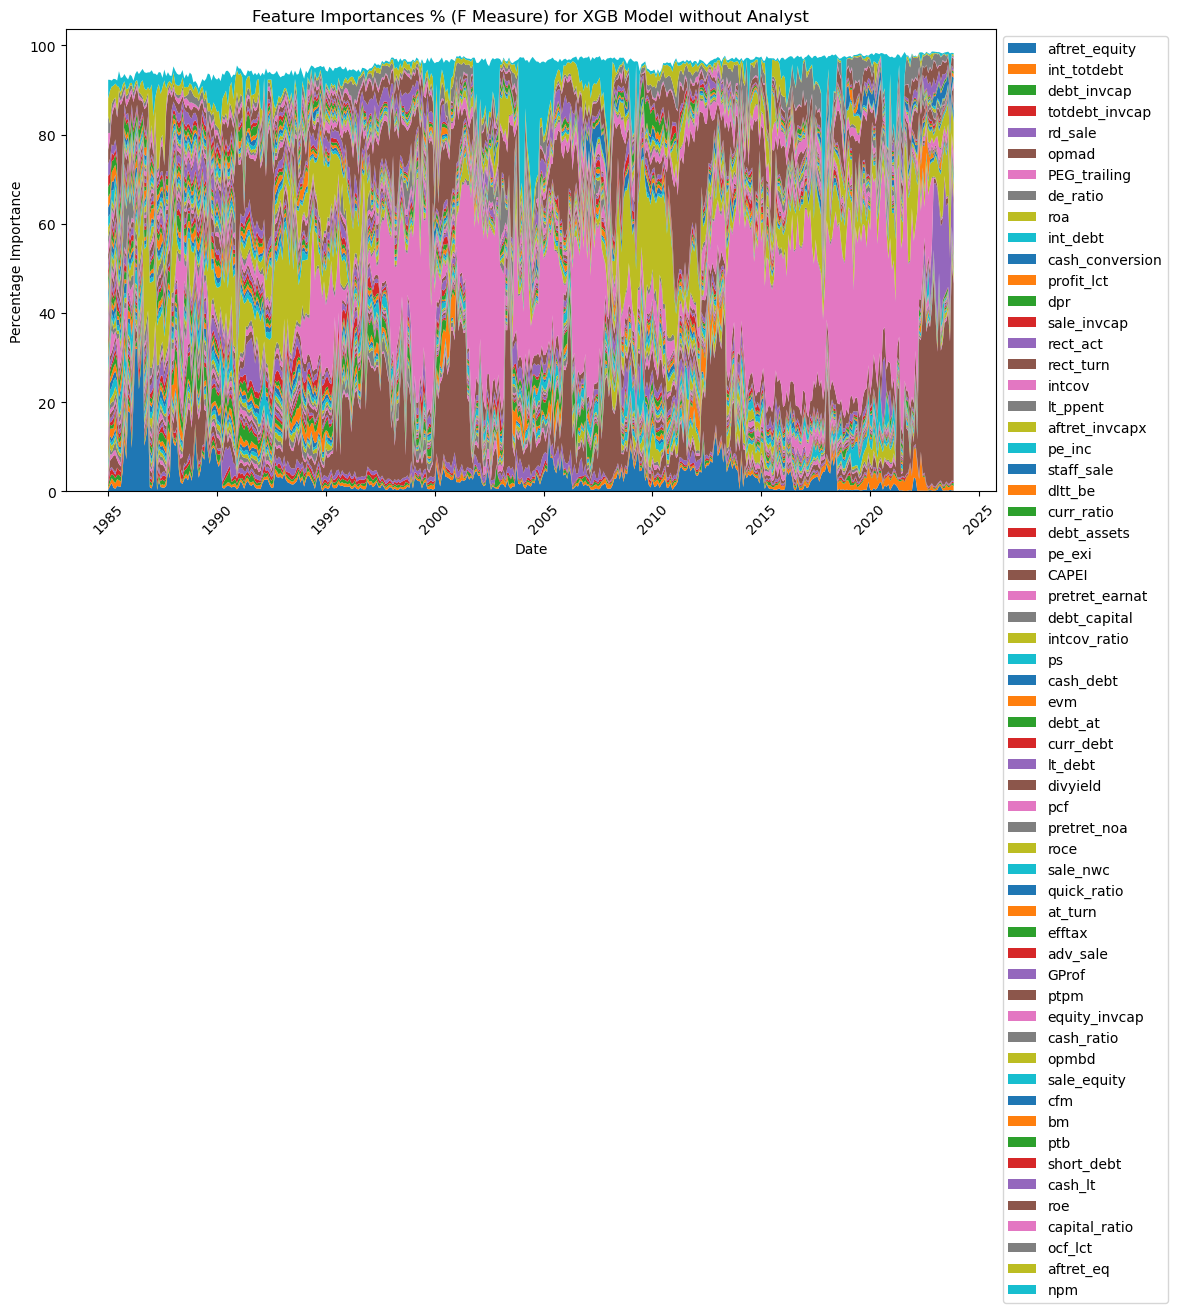

<Figure size 1200x600 with 1 Axes>

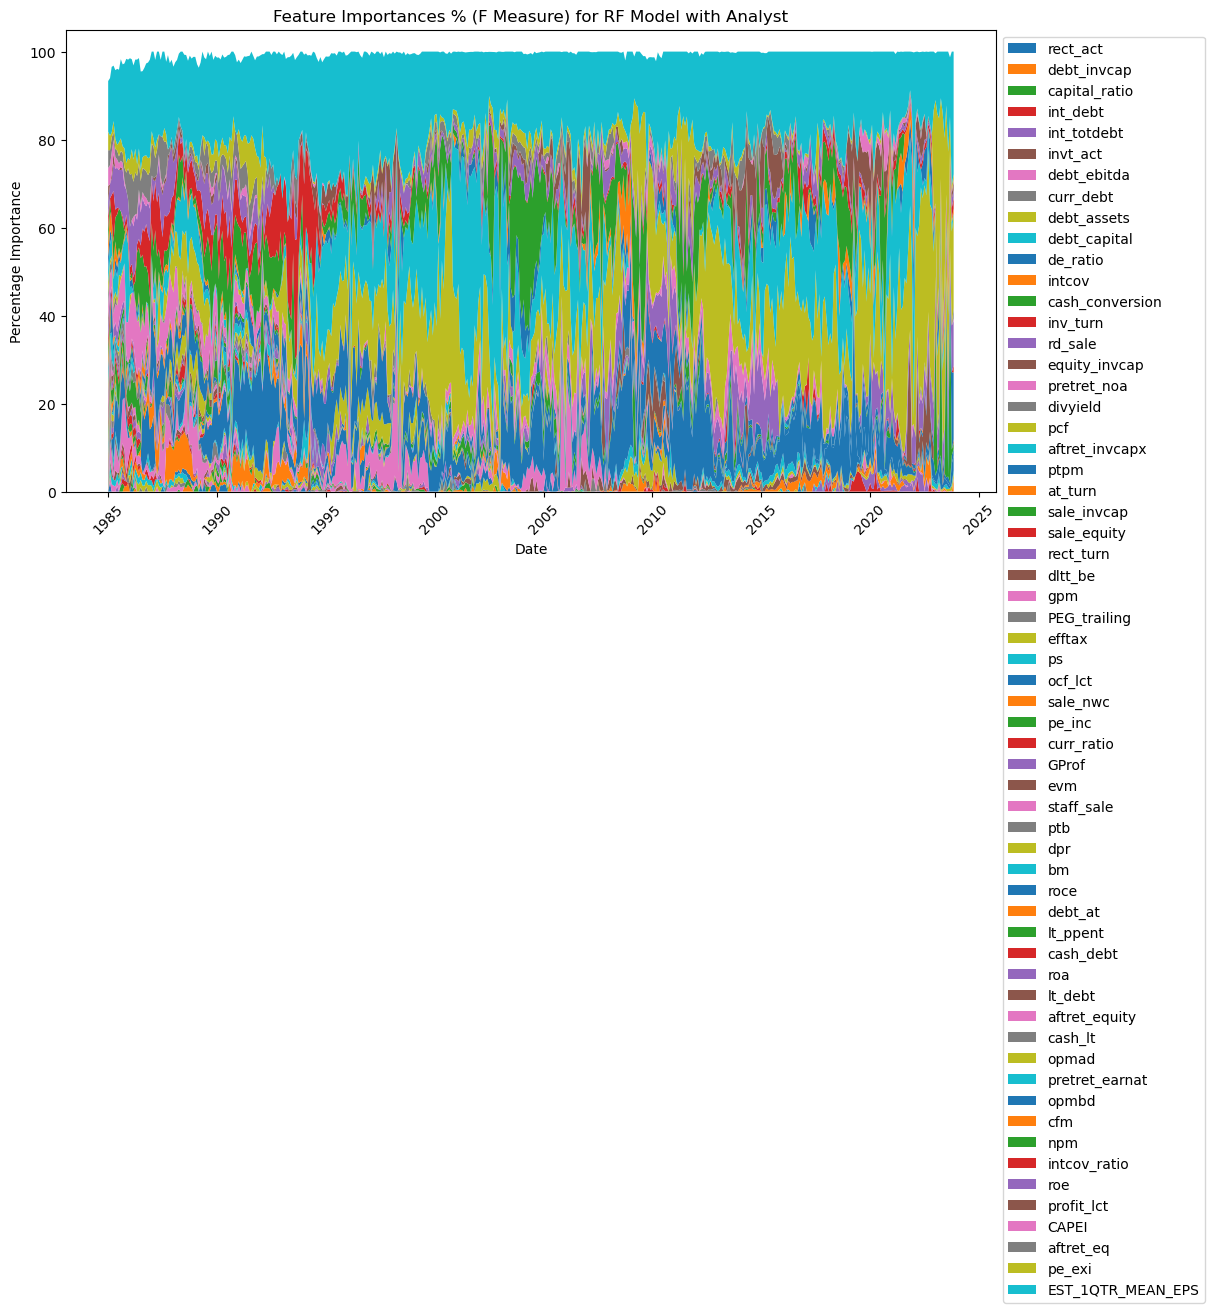

<Figure size 1200x600 with 1 Axes>

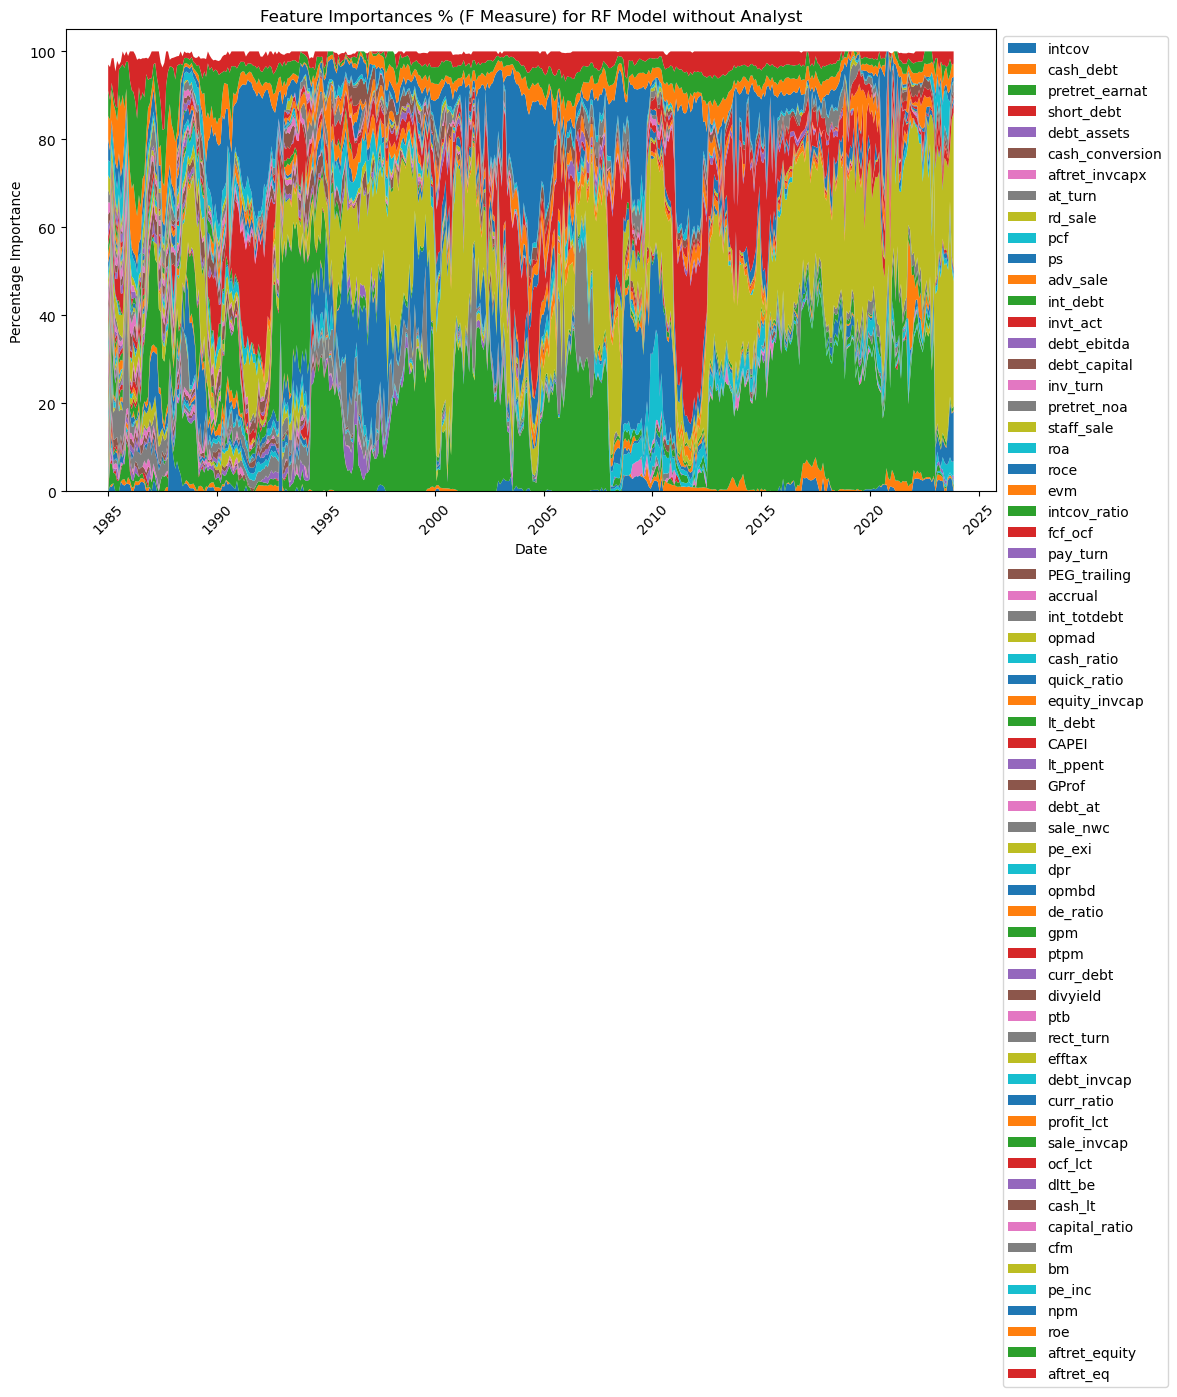

<Figure size 1200x600 with 1 Axes>

In [ ]:
import matplotlib.pyplot as plt
import os

def plot_configurations(config_dfs, output_dir='output_plots'):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Create a plot for each configuration
    for (model_type, with_analyst), df in config_dfs.items():
        plt.figure(figsize=(12, 6))
        # Only keep features with a maximum percentage over a certain threshold (e.g., 2%)
        df = df.loc[:, df.max() > 2]
        plt.stackplot(df.index, [df[feature] for feature in df.columns], labels=df.columns)
        
        title = f'Feature Importances % (F Measure) for {model_type.upper()} Model {"with" if with_analyst == "yes" else "without"} Analyst'
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Percentage Importance')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Generate filename from title
        filename = f"{title.replace(' ', '_').replace('%', 'perc')}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath)
        plt.show()
        print(f"Plot saved as {filename}")

# Example usage
plot_configurations(config_dfs)

In [ ]:
import pandas as pd
from collections import defaultdict

def get_feature_importances_rsquared_by_configuration(df):
    # Initialize a dictionary to store DataFrames for each configuration
    configurations = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

    # Process each row in the DataFrame
    for _, row in df.iterrows():
        date = row['date']
        model_type = row['model_type']
        with_analyst = row['with_analyst']
        feature_importances = row['feature_dict_RSquared']

        total_importance = sum(importance for _, importance in feature_importances)

        for feature, importance in feature_importances:
            if total_importance > 0:  # Avoid division by zero
                configurations[(model_type, with_analyst)][date][feature] += importance

    # Normalize the importances and convert to DataFrame
    result_dfs = {}
    for config, data in configurations.items():
        # Create DataFrame from the nested dictionary
        temp_df = pd.DataFrame.from_dict(data, orient='index').fillna(0)
        # Normalize the importances to sum to 100% per row
        temp_df = temp_df.div(temp_df.sum(axis=1), axis=0) * 100
        result_dfs[config] = temp_df

    return result_dfs

# Example usage, assuming `metrics_df` is your DataFrame
config_dfs = get_feature_importances_rsquared_by_configuration(metrics)



Plot saved as Feature_Importances_perc_(Using_R^2_Drop_Method)_for_XGB_Model_with_Analyst.png



Plot saved as Feature_Importances_perc_(Using_R^2_Drop_Method)_for_XGB_Model_without_Analyst.png



Plot saved as Feature_Importances_perc_(Using_R^2_Drop_Method)_for_RF_Model_with_Analyst.png



Plot saved as Feature_Importances_perc_(Using_R^2_Drop_Method)_for_RF_Model_without_Analyst.png


/var/folders/_d/bmd_6z9569j64hgp6vdh94280000gn/T/ipykernel_85850/117992785.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()



/var/folders/_d/bmd_6z9569j64hgp6vdh94280000gn/T/ipykernel_85850/117992785.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()



/var/folders/_d/bmd_6z9569j64hgp6vdh94280000gn/T/ipykernel_85850/117992785.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()



/var/folders/_d/bmd_6z9569j64hgp6vdh94280000gn/T/ipykernel_85850/117992785.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()




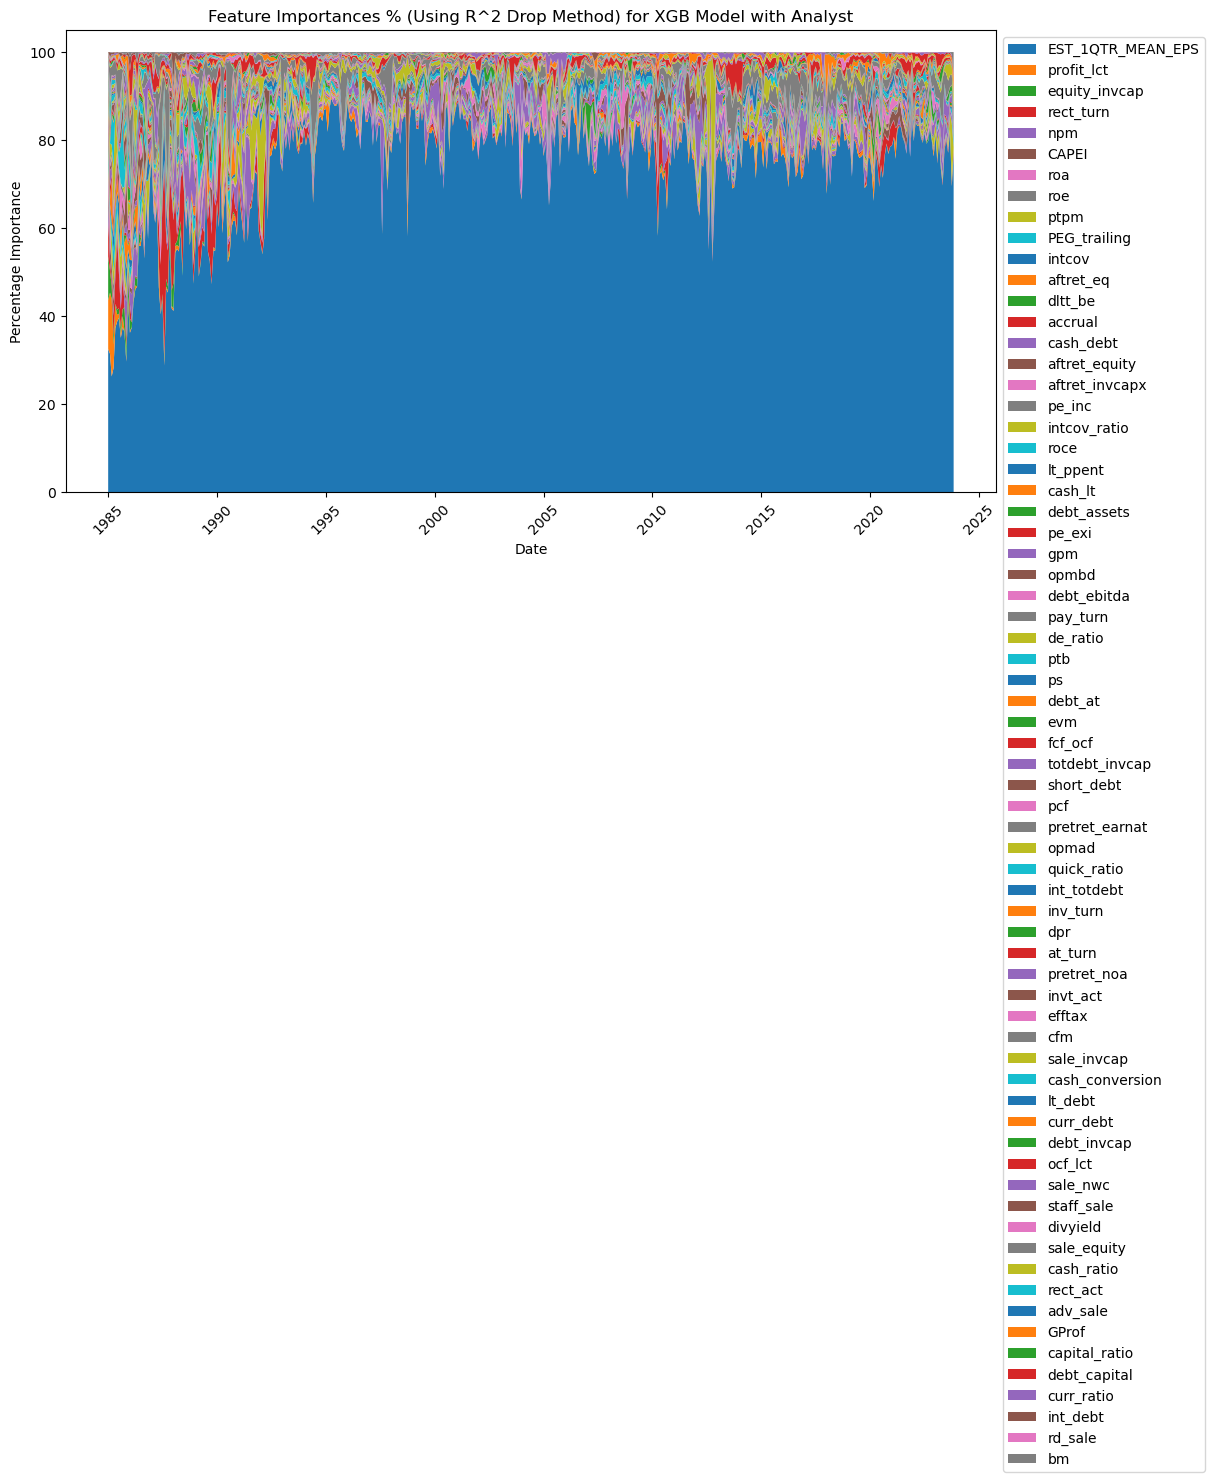

<Figure size 1200x600 with 1 Axes>

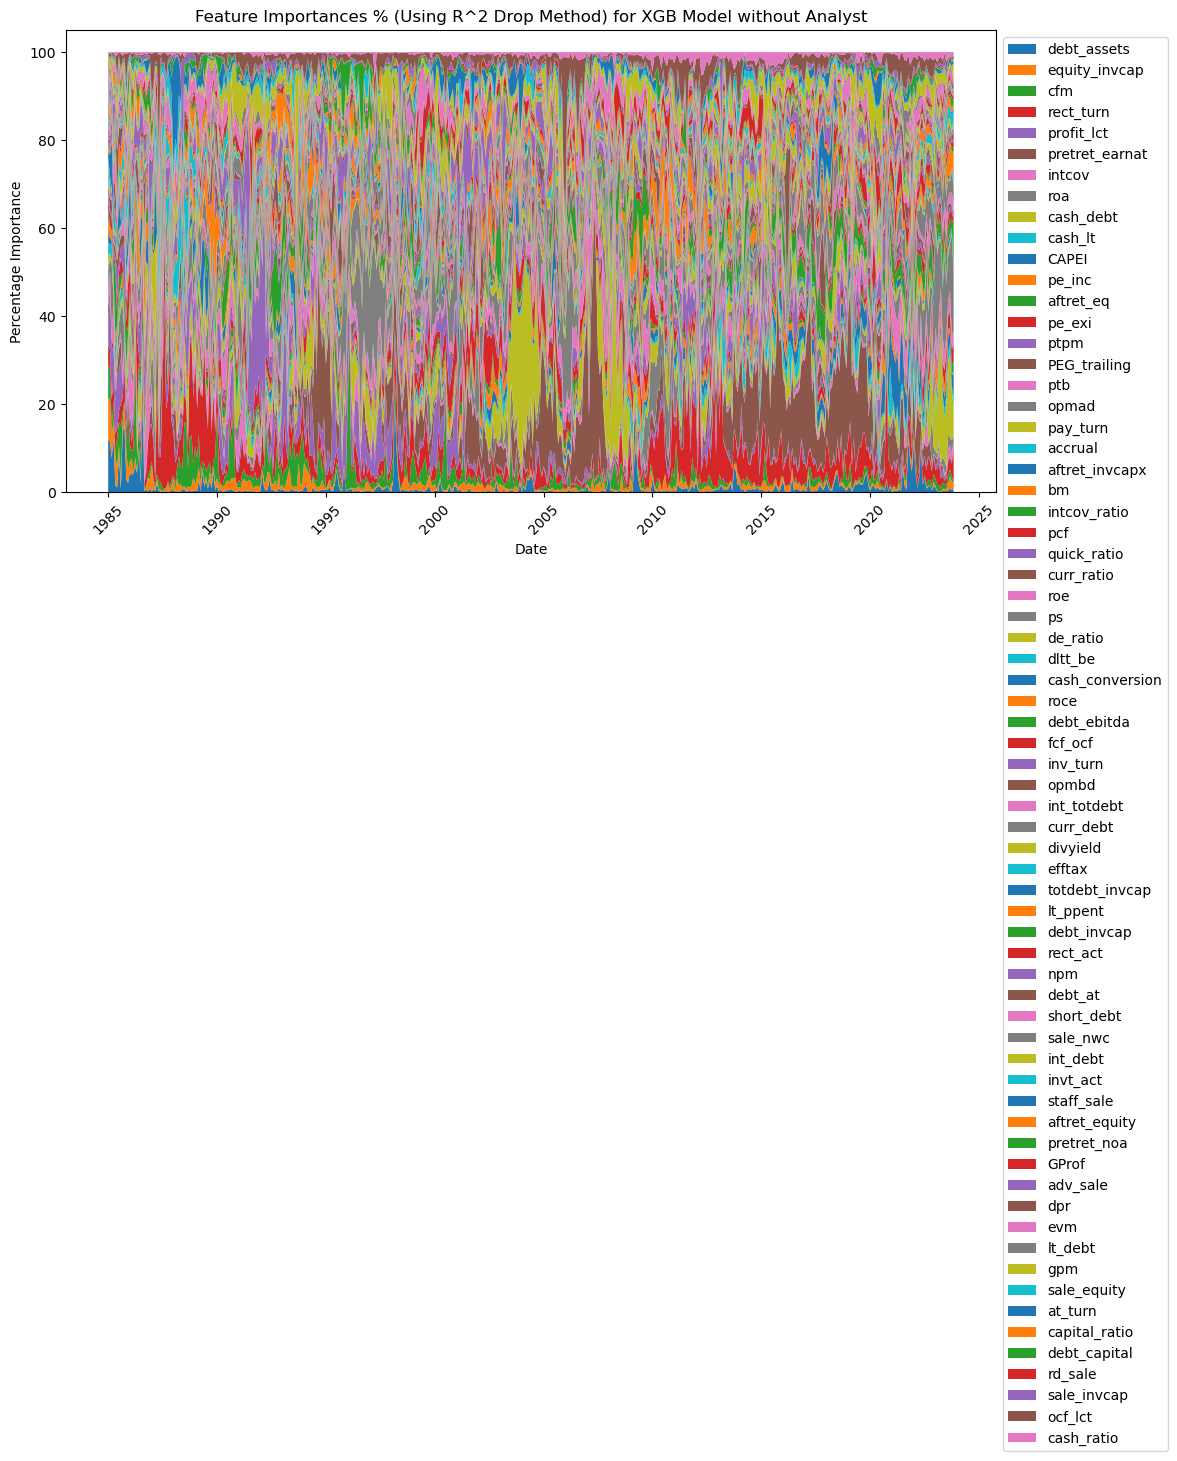

<Figure size 1200x600 with 1 Axes>

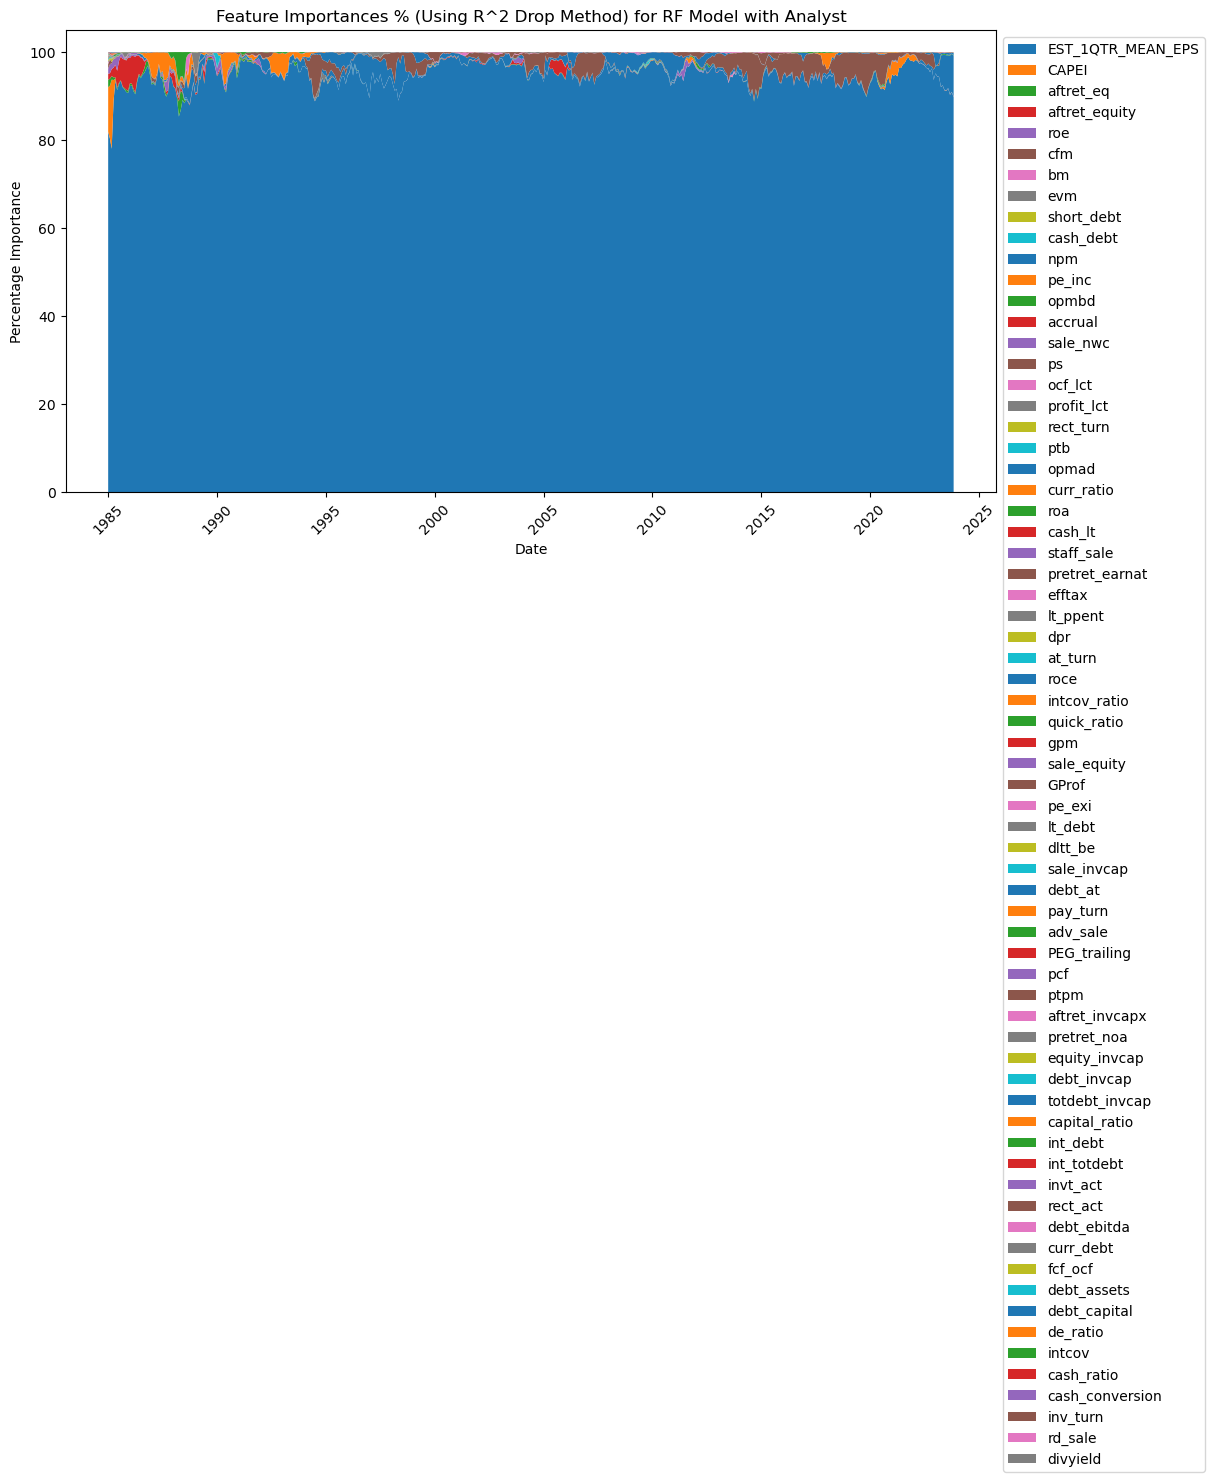

<Figure size 1200x600 with 1 Axes>

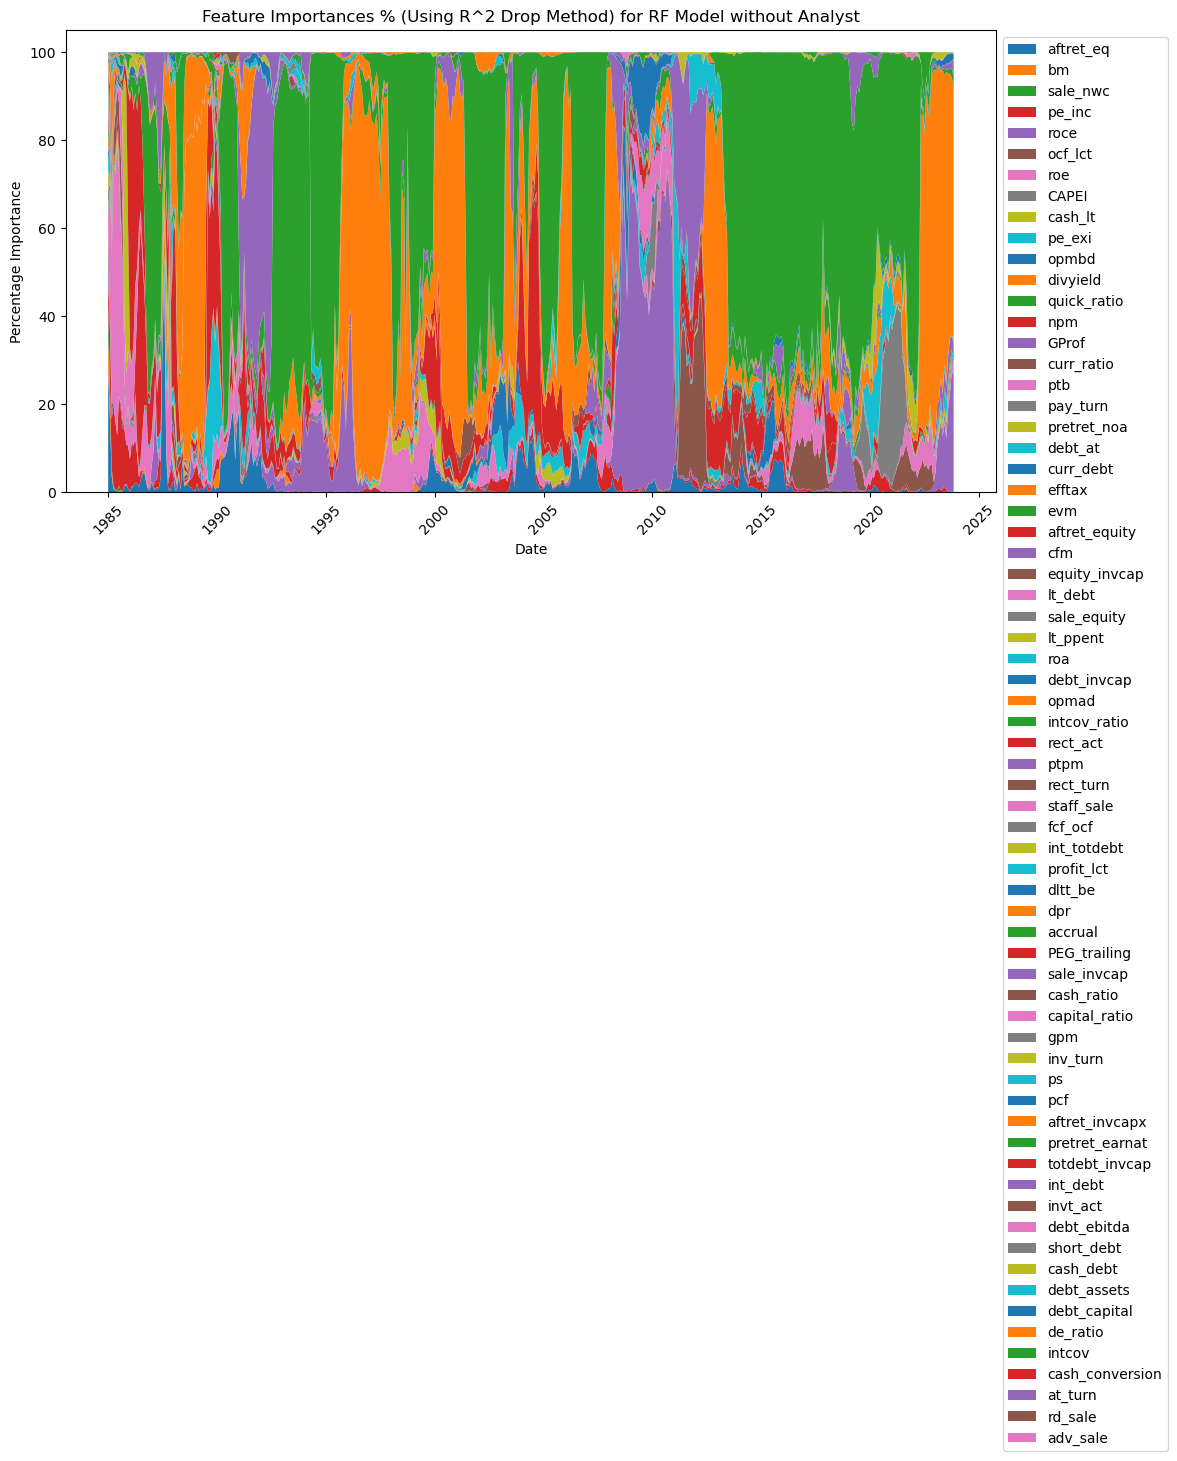

<Figure size 1200x600 with 1 Axes>

In [ ]:
import matplotlib.pyplot as plt
import os

def plot_configurations(config_dfs, output_dir='output_plots'):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Create a plot for each configuration
    for (model_type, with_analyst), df in config_dfs.items():
        plt.figure(figsize=(12, 6))
        # Only keep features with a maximum percentage over a certain threshold (e.g., 2%)
        df = df.loc[:, df.max() > 0]
        plt.stackplot(df.index, [df[feature] for feature in df.columns], labels=df.columns)
        
        title = f'Feature Importances % (Using R^2 Drop Method) for {model_type.upper()} Model {"with" if with_analyst == "yes" else "without"} Analyst'
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Percentage Importance')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Generate filename from title
        filename = f"{title.replace(' ', '_').replace('%', 'perc')}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath)
        plt.show()
        print(f"Plot saved as {filename}")

# Example usage
plot_configurations(config_dfs)

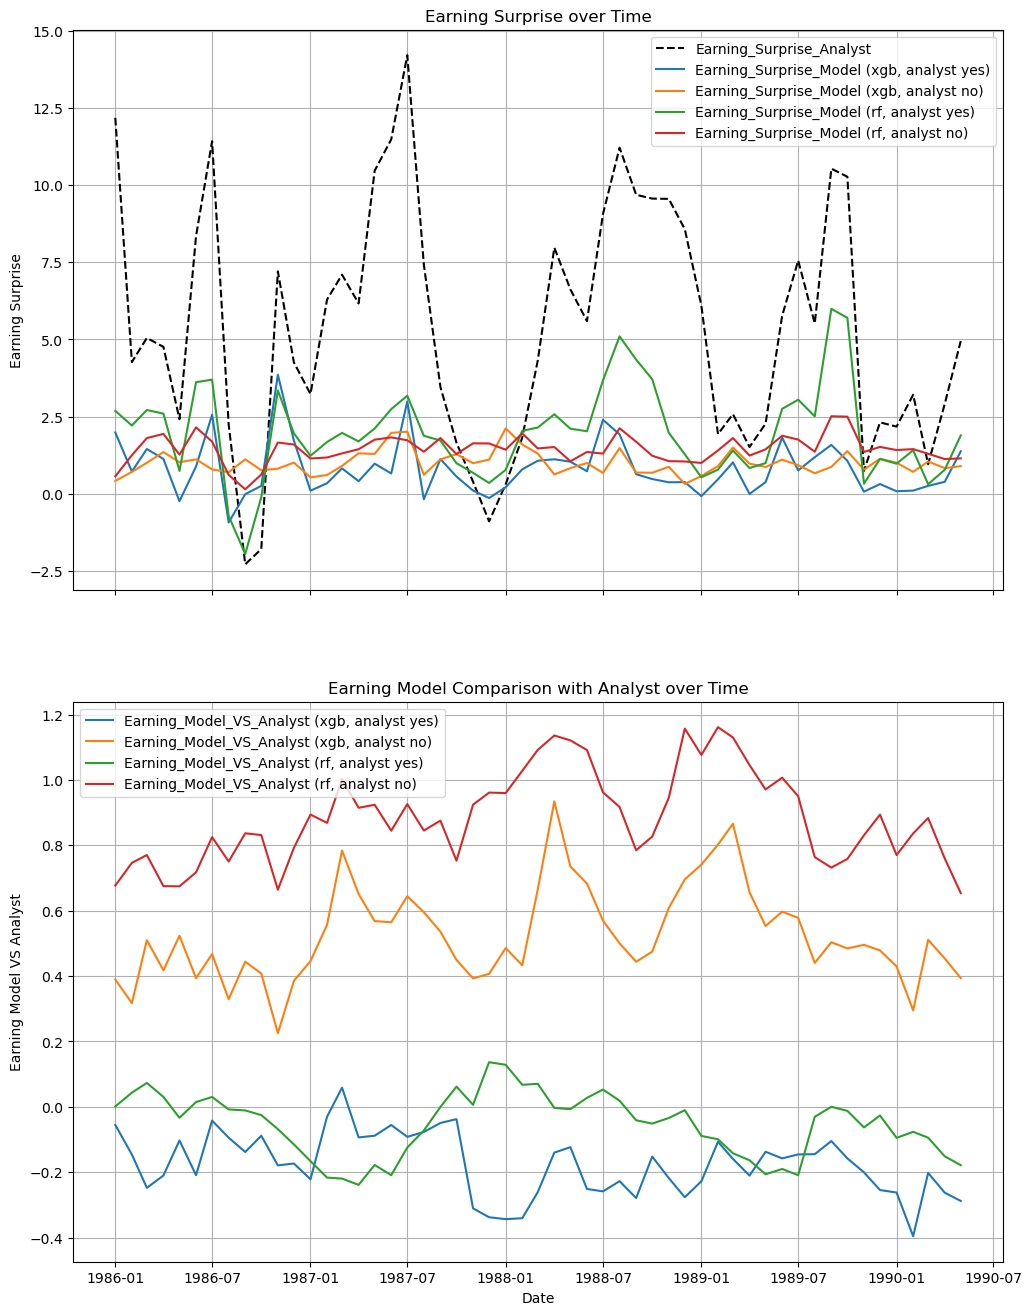

<Figure size 1200x1600 with 2 Axes>

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_earning_surprise(df, output_dir='output_plots'):
    # Ensure 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Separate data by model type and analyst presence
    models = ['xgb', 'rf']
    analyst_options = ['yes', 'no']
    
    # Initialize the plot with subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 16), sharex=True)

    # Plot Earning_Surprise_Analyst on the first subplot
    axs[0].plot(df['date'], df['Earning_Surprise_Analyst'], label='Earning_Surprise_Analyst', linestyle='--', color='black')
    
    # Plot Earning_Surprise_Model for each combination of model and analyst on the first subplot
    for model in models:
        for analyst in analyst_options:
            subset = df[(df['model_type'] == model) & (df['with_analyst'] == analyst)]
            label = f'Earning_Surprise_Model ({model}, analyst {analyst})'
            axs[0].plot(subset['date'], subset['Earning_Surprise_Model'], label=label)

    # Add labels and legend to the first subplot
    axs[0].set_ylabel('Earning Surprise')
    axs[0].set_title('Earning Surprise over Time')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot Earning_Model_VS_Analyst on the second subplot
    for model in models:
        for analyst in analyst_options:
            subset = df[(df['model_type'] == model) & (df['with_analyst'] == analyst)]
            label = f'Earning_Model_VS_Analyst ({model}, analyst {analyst})'
            axs[1].plot(subset['date'], subset['Earning_Model_VS_Analyst'], label=label)

    # Add labels and legend to the second subplot
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Earning Model VS Analyst')
    axs[1].set_title('Earning Model Comparison with Analyst over Time')
    axs[1].legend()
    axs[1].grid(True)
    
    # Save plot
    filename = 'Earning_Surprise_and_Comparison_over_Time.png'
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    
    # Show plot
    plt.show()

plot_earning_surprise(metrics)